In [1]:
#!pip install category_encoders

In [2]:
#!pip install catboost

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import random
import os
import warnings
import easydict
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# train_df = pd.read_csv('/content/drive/MyDrive/dev/ML_basic/train.csv')
# test_df = pd.read_csv('/content/drive/MyDrive/dev/ML_basic/test.csv')

train_df = pd.read_csv('C:/dev/ML_basic/train.csv')
test_df = pd.read_csv('C:/dev/ML_basic/test.csv')

In [5]:
# train_df = train_df[train_df['price(원/kg)'] != 0]

# 함수 정의

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# 시계열 특성 사용

In [7]:
#시계열 특성을 학습에 반영하기 위해 timestamp를 월, 일, 시간으로 나눕니다
train_df['year'] = train_df['timestamp'].apply(lambda x : int(x[0:4]))
train_df['month'] = train_df['timestamp'].apply(lambda x : int(x[5:7]))
train_df['day'] = train_df['timestamp'].apply(lambda x : int(x[8:10]))

test_df['year'] = test_df['timestamp'].apply(lambda x : int(x[0:4]))
test_df['month'] = test_df['timestamp'].apply(lambda x : int(x[5:7]))
test_df['day'] = test_df['timestamp'].apply(lambda x : int(x[8:10]))

In [8]:
# 일요일 column 추가
def sunday(day):
    out=0
    if day ==6:
        out=1
    return out

train_df['날짜'] = pd.to_datetime(train_df['timestamp'])
train_df['요일'] = train_df['날짜'].dt.dayofweek

train_df['sunday']= train_df.apply(lambda x : sunday(x['요일']),axis=1)

test_df['날짜'] = pd.to_datetime(test_df['timestamp'])
test_df['요일'] = test_df['날짜'].dt.dayofweek

test_df['sunday']= test_df.apply(lambda x : sunday(x['요일']),axis=1)


train_df.drop(columns=['날짜', '요일'],inplace=True)
test_df.drop(columns=['날짜', '요일'],inplace=True)

train_df.tail(10)

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,sunday
59387,RD_F_J_20230222,2023-02-22,RD,F,J,512400.0,440.0,2023,2,22,0
59388,RD_F_J_20230223,2023-02-23,RD,F,J,478360.0,396.0,2023,2,23,0
59389,RD_F_J_20230224,2023-02-24,RD,F,J,466440.0,388.0,2023,2,24,0
59390,RD_F_J_20230225,2023-02-25,RD,F,J,250580.0,429.0,2023,2,25,0
59391,RD_F_J_20230226,2023-02-26,RD,F,J,0.0,0.0,2023,2,26,1
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,2023,2,27,0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,2023,2,28,0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,2023,3,1,0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,2023,3,2,0
59396,RD_F_J_20230303,2023-03-03,RD,F,J,427520.0,529.0,2023,3,3,0


In [9]:
# !pip install workalendar

In [10]:
# 공휴일 column 추가
import pandas as pd
from datetime import datetime
from workalendar.asia import SouthKorea

# SouthKorea 객체 생성
cal = SouthKorea()

# 시작과 끝 날짜 설정
start_date = datetime(2019, 1, 1)
end_date = datetime(2023, 3, 3)

# 날짜 범위 생성
date_range = pd.date_range(start=start_date, end=end_date, freq='D')


# 한국의 공휴일 데이터프레임 생성 (대체 공휴일 포함)
korean_holidays = pd.DataFrame(date_range, columns=['Date'])
korean_holidays['Holiday'] = korean_holidays['Date'].apply(lambda x: cal.is_holiday(x))
#korean_holidays['workingday'] = korean_holidays['Date'].apply(lambda x: cal.is_working_day(x))
# korean_holidays = korean_holidays[korean_holidays['Holiday'] == True]

korean_holidays=korean_holidays.rename(columns={'Date':'timestamp'})

# 결과 출력
korean_holidays

,timestamp,Holiday
0,2019-01-01,True
1,2019-01-02,False
2,2019-01-03,False
3,2019-01-04,False
4,2019-01-05,False
...,...,...
1518,2023-02-27,False
1519,2023-02-28,False
1520,2023-03-01,True
1521,2023-03-02,False


In [11]:
# 형변환 하는데 나중에 문제 생긴다면 수정하자
# bool type을 int형으로 변환
korean_holidays['Holiday']=korean_holidays['Holiday'].astype(int)

# merge할 두 df의 type을 맞춰 주기위함이다. korean은 datetime, train은 object의 형태였다.
korean_holidays['timestamp']=korean_holidays['timestamp'].astype(str)
train_df['timestamp']=train_df['timestamp'].astype(str)
test_df['timestamp']=test_df['timestamp'].astype(str)

In [12]:
# 날짜가 같으면 합쳐짐 열만 하나 추가 row는 변화없음
train_df=pd.merge(train_df,korean_holidays, on='timestamp', how='left')
test_df=pd.merge(test_df,korean_holidays, on='timestamp', how='left')

# 과일 종류별로 데이터 분리

In [13]:
def classify_item(x):
    item=None
    #x=str(x)
    if 'TG' in x:
        item='TG'
    elif 'BC' in x:
        item='BC'
    elif 'CR' in x:
        item='CR'
    elif 'CB' in x:
        item='CB'
    elif 'RD' in x:
        item='RD'
    return item
train_df['item']=train_df.apply(lambda x: classify_item(x['ID']),axis=1)
test_df['item']=test_df.apply(lambda x: classify_item(x['ID']),axis=1)


In [14]:
train_df.loc[train_df['item']=='TG'].tail(60)

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,sunday,Holiday
15170,TG_E_S_20230103,2023-01-03,TG,E,S,59219.8,2077.0,2023,1,3,0,0
15171,TG_E_S_20230104,2023-01-04,TG,E,S,52822.0,1897.0,2023,1,4,0,0
15172,TG_E_S_20230105,2023-01-05,TG,E,S,28964.0,1990.0,2023,1,5,0,0
15173,TG_E_S_20230106,2023-01-06,TG,E,S,31985.0,1969.0,2023,1,6,0,0
15174,TG_E_S_20230107,2023-01-07,TG,E,S,41328.2,2030.0,2023,1,7,0,0
15175,TG_E_S_20230108,2023-01-08,TG,E,S,0.0,0.0,2023,1,8,1,0
15176,TG_E_S_20230109,2023-01-09,TG,E,S,37034.2,2729.0,2023,1,9,0,0
15177,TG_E_S_20230110,2023-01-10,TG,E,S,23664.0,3098.0,2023,1,10,0,0
15178,TG_E_S_20230111,2023-01-11,TG,E,S,57848.2,2605.0,2023,1,11,0,0
15179,TG_E_S_20230112,2023-01-12,TG,E,S,52451.2,2431.0,2023,1,12,0,0


# EDA

In [15]:
train_df['corporation'].value_counts()

corporation
A    13707
E    13707
D    12184
C     9138
B     7615
F     3046
Name: count, dtype: int64

In [16]:
# 기업별 0의 갯수
print(train_df.loc[train_df['corporation']=='A'].loc[train_df['supply(kg)']==0].shape)
print(train_df.loc[train_df['corporation']=='E'].loc[train_df['supply(kg)']==0].shape)
print(train_df.loc[train_df['corporation']=='D'].loc[train_df['supply(kg)']==0].shape)
print(train_df.loc[train_df['corporation']=='C'].loc[train_df['supply(kg)']==0].shape)
print(train_df.loc[train_df['corporation']=='B'].loc[train_df['supply(kg)']==0].shape)
print(train_df.loc[train_df['corporation']=='F'].loc[train_df['supply(kg)']==0].shape)

(7897, 12)
(8508, 12)
(7263, 12)
(5743, 12)
(4383, 12)
(1658, 12)


In [17]:
train_df['corporation'].value_counts()

corporation
A    13707
E    13707
D    12184
C     9138
B     7615
F     3046
Name: count, dtype: int64

In [18]:
# 기업별 0의 갯수
print(train_df.loc[train_df['corporation']=='A'].loc[train_df['price(원/kg)']==0].shape)
print(train_df.loc[train_df['corporation']=='E'].loc[train_df['price(원/kg)']==0].shape)
print(train_df.loc[train_df['corporation']=='D'].loc[train_df['price(원/kg)']==0].shape)
print(train_df.loc[train_df['corporation']=='C'].loc[train_df['price(원/kg)']==0].shape)
print(train_df.loc[train_df['corporation']=='B'].loc[train_df['price(원/kg)']==0].shape)
print(train_df.loc[train_df['corporation']=='F'].loc[train_df['price(원/kg)']==0].shape)

(7898, 12)
(8509, 12)
(7264, 12)
(5743, 12)
(4383, 12)
(1658, 12)


In [19]:
train_df['location'].value_counts()

location
J    35029
S    24368
Name: count, dtype: int64

In [20]:
# 지역별 0의 갯수
print(train_df.loc[train_df['location']=='J'].loc[train_df['supply(kg)']==0].shape)
print(train_df.loc[train_df['location']=='S'].loc[train_df['supply(kg)']==0].shape)

(20099, 12)
(15353, 12)


In [21]:
# price = 0 인데, supply != 0 인경우 3개가 존재
train_df.loc[train_df['corporation']=='A'].loc[(train_df['price(원/kg)']==0) & (train_df['supply(kg)']!=0)]

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,sunday,Holiday
825,TG_A_J_20210405,2021-04-05,TG,A,J,64.0,0.0,2021,4,5,0,0


In [22]:
train_df.loc[train_df['corporation']=='E'].loc[(train_df['price(원/kg)']==0) & (train_df['supply(kg)']!=0)]

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,sunday,Holiday
31199,CB_E_J_20210109,2021-01-09,CB,E,J,80.0,0.0,2021,1,9,0,0


In [23]:
train_df.loc[train_df['corporation']=='D'].loc[(train_df['price(원/kg)']==0) & (train_df['supply(kg)']!=0)]

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,sunday,Holiday
9266,TG_D_J_20190509,2019-05-09,TG,D,J,129.0,0.0,2019,5,9,0,0


# 학습에 사용할 변수 정의

In [24]:
# 학습에 사용하지 않을 변수들을 제거
train_X = train_df.drop(columns=['ID', 'timestamp', 'supply(kg)', 'price(원/kg)'])
train_Y = train_df[['price(원/kg)']]

test_X = test_df.drop(columns=['ID', 'timestamp'])

test에는 supply(kg)이 없음

# 수치형 스케일링

In [25]:
list(train_X.columns)

['item',
 'corporation',
 'location',
 'year',
 'month',
 'day',
 'sunday',
 'Holiday']

In [26]:
list(test_X.columns)

['item',
 'corporation',
 'location',
 'year',
 'month',
 'day',
 'sunday',
 'Holiday']

In [27]:
no_category_cols = []
category_cols = list(train_X.columns)

train_no_category = train_X[no_category_cols]
train_category = train_X[category_cols]

train_no_category.shape, train_category.shape

((59397, 0), (59397, 8))

In [28]:
no_category_cols = []
category_cols = list(test_X.columns)

test_no_category = test_X[no_category_cols]
test_category = test_X[category_cols]

test_no_category.shape, test_category.shape

((1092, 0), (1092, 8))

In [29]:
'''# 스케일링 적용할 컬럼 선언
scaling_cols = ['supply(kg)']

# 수치형 데이터 프레임에서 스케일링 적용할 컬럼이 포함된 데이터 프레임 생성
train_scaling = train_no_category[scaling_cols]
#test_scaling = test_no_category[scaling_cols]

print(f'{train_scaling.shape}')# / {test_scaling.shape}')
train_scaling.head(3)'''

"# 스케일링 적용할 컬럼 선언\nscaling_cols = ['supply(kg)']\n\n# 수치형 데이터 프레임에서 스케일링 적용할 컬럼이 포함된 데이터 프레임 생성\ntrain_scaling = train_no_category[scaling_cols]\n#test_scaling = test_no_category[scaling_cols]\n\nprint(f'{train_scaling.shape}')# / {test_scaling.shape}')\ntrain_scaling.head(3)"

In [30]:
'''from sklearn.preprocessing import StandardScaler'''

'from sklearn.preprocessing import StandardScaler'

In [31]:
'''# 인스턴스 생성
std = StandardScaler()'''

'# 인스턴스 생성\nstd = StandardScaler()'

In [32]:
'''std.fit(train_scaling)'''

'std.fit(train_scaling)'

In [33]:
'''# 반영
X_train_scaled = std.transform(train_scaling)
X_test_scaled = std.transform(test_scaling)'''

'# 반영\nX_train_scaled = std.transform(train_scaling)\nX_test_scaled = std.transform(test_scaling)'

In [34]:
'''X_train_scaled.shape, X_test_scaled.shape'''

'X_train_scaled.shape, X_test_scaled.shape'

In [35]:
'''train_scaling.shape, test_scaling.shape'''

'train_scaling.shape, test_scaling.shape'

# 수치형, 범주형 합치기

In [36]:
_train_encoded = pd.DataFrame()
_test_encoded = pd.DataFrame()

for col in category_cols:
  _encoder = ce.OneHotEncoder(use_cat_names=True)
  _encoder.fit(train_category[col])
  _encoded = _encoder.transform(train_category[col])
  _train_encoded = pd.concat([_train_encoded, _encoded], axis=1)

  _encoded = _encoder.transform(test_category[col])
  _test_encoded = pd.concat([_test_encoded, _encoded], axis=1)

In [37]:
train_encoded = pd.concat([train_no_category, _train_encoded], axis=1)
train_encoded.shape

(59397, 18)

In [38]:
train_encoded

,item_TG,item_CR,item_CB,item_RD,item_BC,corporation_A,corporation_B,corporation_C,corporation_D,corporation_E,corporation_F,location_J,location_S,year,month,day,sunday,Holiday
0,1,0,0,0,0,1,0,0,0,0,0,1,0,2019,1,1,0,1
1,1,0,0,0,0,1,0,0,0,0,0,1,0,2019,1,2,0,0
2,1,0,0,0,0,1,0,0,0,0,0,1,0,2019,1,3,0,0
3,1,0,0,0,0,1,0,0,0,0,0,1,0,2019,1,4,0,0
4,1,0,0,0,0,1,0,0,0,0,0,1,0,2019,1,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,0,0,0,1,0,0,0,0,0,0,1,1,0,2023,2,27,0,0
59393,0,0,0,1,0,0,0,0,0,0,1,1,0,2023,2,28,0,0
59394,0,0,0,1,0,0,0,0,0,0,1,1,0,2023,3,1,0,1
59395,0,0,0,1,0,0,0,0,0,0,1,1,0,2023,3,2,0,0


In [39]:
test_encoded = pd.concat([test_no_category, _test_encoded], axis=1)
test_encoded.shape

(1092, 18)

In [40]:
train_target = train_Y
train_features = train_encoded

train_features.shape, train_target.shape

((59397, 18), (59397, 1))

# K-Fold

In [41]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV

In [42]:
# 교차 검증
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)

## DecisionTree

In [43]:
from sklearn.tree import DecisionTreeClassifier

In [44]:
from sklearn.metrics import mean_squared_error

model = DecisionTreeClassifier(random_state=42)

n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
    train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

    # 학습
    model.fit(train_x, train_y)
    valid_pred = model.predict(valid_x)  # 예측값

    # 평가
    rmse = mean_squared_error(valid_y, valid_pred, squared=False)
    rmse_lst.append(rmse)
    print(f'{n_iter} 번째 Stratified Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified Stratified K-Fold RMSE: 1181.485554184847
2 번째 Stratified Stratified K-Fold RMSE: 1080.7963930511255
3 번째 Stratified Stratified K-Fold RMSE: 1102.6676053456852
4 번째 Stratified Stratified K-Fold RMSE: 1130.3803272396979
5 번째 Stratified Stratified K-Fold RMSE: 1163.9138579960443
6 번째 Stratified Stratified K-Fold RMSE: 1163.7829350315694
--------------------------------------------------
교차 검증 RMSE: 1137.1711121414949


## XGBoost

### model 1

In [45]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [46]:
hp = {
    "random_state" : 42
}

model = XGBRegressor(**hp)
n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 890.8099798959263
2 번째 Stratified K-Fold RMSE: 882.47458898719
3 번째 Stratified K-Fold RMSE: 847.5484429063554
4 번째 Stratified K-Fold RMSE: 876.9214542213845
5 번째 Stratified K-Fold RMSE: 908.8509682611185
6 번째 Stratified K-Fold RMSE: 906.1490792873766
--------------------------------------------------
교차 검증 RMSE: 885.4590855932252


### model 2

In [47]:
hp = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
model = XGBRegressor(**hp)

In [54]:
np.logspace(-3, -1, 3)

array([0.001, 0.01 , 0.1  ])

In [48]:
n_iter=3 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(800,1200,20, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
best_params = rs1.best_params_
best_params

{'n_estimators': 968, 'max_depth': 6, 'learning_rate': 0.1}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

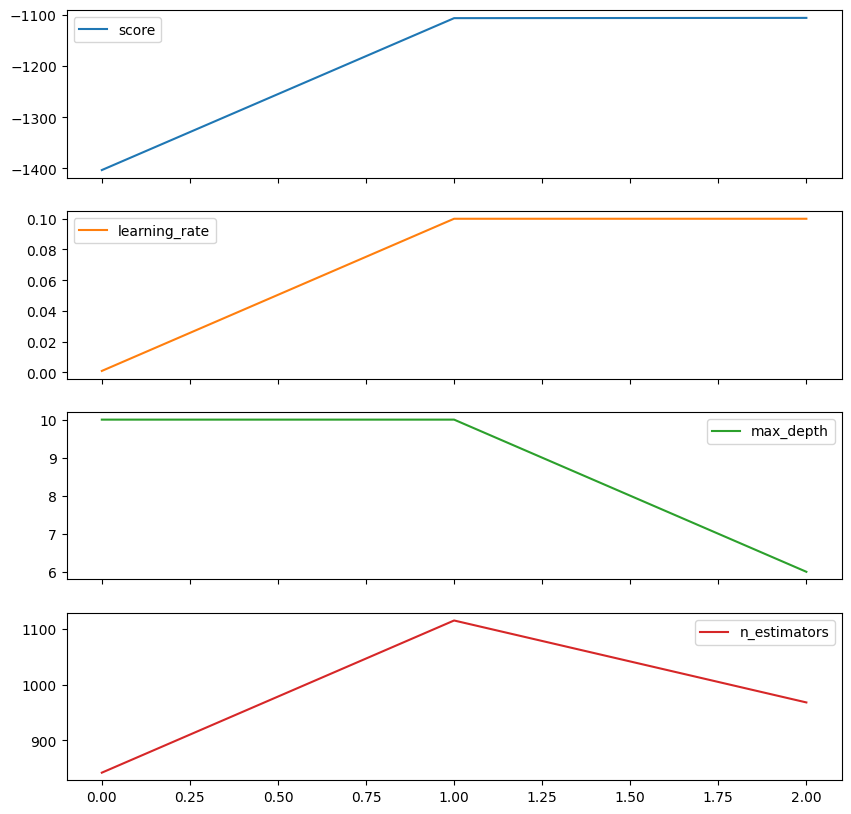

In [ ]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
best_params['random_state'] = 42
best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
best_mode = XGBRegressor(**hp)

In [ ]:
n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1139.9807709623733
2 번째 Stratified K-Fold RMSE: 1158.4771900348048
3 번째 Stratified K-Fold RMSE: 1124.838688625251
4 번째 Stratified K-Fold RMSE: 1162.50970861524
5 번째 Stratified K-Fold RMSE: 1160.8171243571069
--------------------------------------------------
교차 검증 RMSE: 1149.324696518955


## Light GBM

### model 0

In [ ]:
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import mean_squared_error

In [ ]:
hp= {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',  # 회귀 모델의 성능 측정 메트릭 (Root Mean Squared Error)
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose' : -1
}
model = LGBMRegressor(**hp)
n_iter = 0
accuracy_lst = []
rmse_lst = []
for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  tr_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  tr_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(tr_x, tr_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1204.7237958886394
2 번째 Stratified K-Fold RMSE: 1227.1813551069872
3 번째 Stratified K-Fold RMSE: 1201.877105452074
4 번째 Stratified K-Fold RMSE: 1233.8874647750151
5 번째 Stratified K-Fold RMSE: 1232.1132498723193
--------------------------------------------------
교차 검증 RMSE: 1219.956594219007


In [ ]:
model = LGBMRegressor(**hp)
n_iter=3 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(2,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(1000,2000,20, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -0.8, 20)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=3)
# 학습 (best hp 조합 찾기)
rs1.fit(train_features, train_target)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


-1204.4630293420505

In [ ]:
best_params = rs1.best_params_
best_params

{'n_estimators': 1789, 'max_depth': 10, 'learning_rate': 0.004951500669473132}

In [ ]:
best_params.keys

<function dict.keys>

In [ ]:
hp= {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',  # 회귀 모델의 성능 측정 메트릭 (Root Mean Squared Error)
    'num_leaves': 31,
    #'learning_rate': 0.05,
    'verbose' : -1,
    'n_estimators': 1473, 'max_depth': 7, 'learning_rate': 0.032008340465997674
}
model = LGBMRegressor(**hp)
n_iter = 0
accuracy_lst = []
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  tr_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  tr_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(tr_x, tr_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1139.4789236208585
2 번째 Stratified K-Fold RMSE: 1153.908641811846
3 번째 Stratified K-Fold RMSE: 1122.4822330564618
4 번째 Stratified K-Fold RMSE: 1165.8001149460642
5 번째 Stratified K-Fold RMSE: 1166.0887342440908
--------------------------------------------------
교차 검증 RMSE: 1149.5517295358645


### model 1

In [ ]:
hp = {
    "random_state" : 42,
    'verbose' : -1
}
model = LGBMRegressor(**hp)
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1183.5800031020576
2 번째 Stratified K-Fold RMSE: 1199.2767709018467
3 번째 Stratified K-Fold RMSE: 1176.5316833784498
4 번째 Stratified K-Fold RMSE: 1206.8214223234947
5 번째 Stratified K-Fold RMSE: 1208.220070835284
--------------------------------------------------
교차 검증 RMSE: 1172.2188598220455


### model 2

In [ ]:
hp = {
    "random_state" : 42,
    "verbose": -1, # 로그
}
model = LGBMRegressor(**hp)

In [ ]:
n_iter=3 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(800,1200,100, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

-1092.2173017115583

In [ ]:
best_params = rs1.best_params_
best_params

{'n_estimators': 1078, 'max_depth': 10, 'learning_rate': 0.1}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

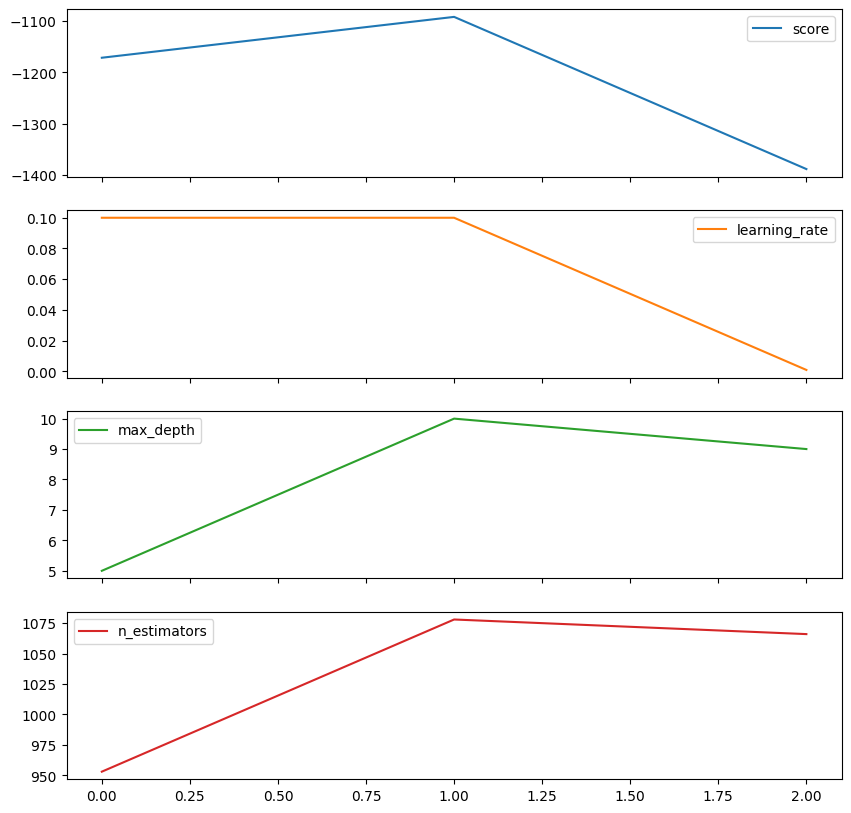

In [ ]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
best_params['random_state'] = 42
best_params['verbose'] = -1

# best 모델 인스턴스 생성(정의)
best_mode = LGBMRegressor(**best_params)

In [ ]:
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1183.5800031020576
2 번째 Stratified K-Fold RMSE: 1199.2767709018467
3 번째 Stratified K-Fold RMSE: 1176.5316833784498
4 번째 Stratified K-Fold RMSE: 1206.8214223234947
5 번째 Stratified K-Fold RMSE: 1208.220070835284
--------------------------------------------------
교차 검증 RMSE: 1179.7745699174388


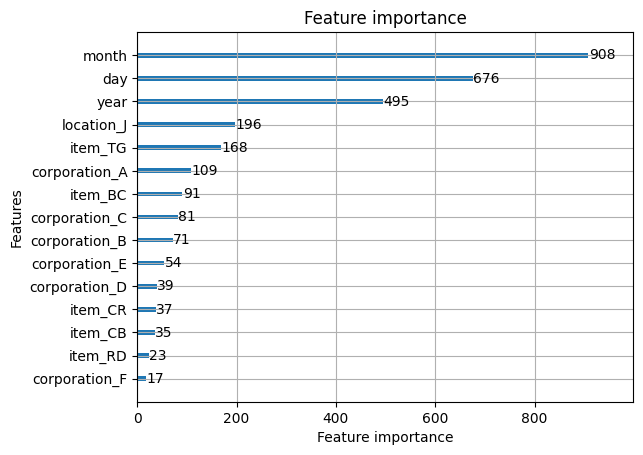

In [ ]:
plot_importance(model)
plt.show()

## catboost

### model 1

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
hp = {
    "random_state" : 42,
    "verbose" : 0 # 부스팅 단계 출력 안보이게 하기
}
model = CatBoostRegressor(**hp)
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1160.4498879620996
2 번째 Stratified K-Fold RMSE: 1174.3370134919671
3 번째 Stratified K-Fold RMSE: 1148.7386710385438
4 번째 Stratified K-Fold RMSE: 1187.6263061825628
5 번째 Stratified K-Fold RMSE: 1185.4321890434246
--------------------------------------------------
교차 검증 RMSE: 1177.6601308240095


### model 2

In [ ]:
hp = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
model = CatBoostRegressor(**hp)

In [ ]:
n_iter=5 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(10,500,20, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

-1083.7649929630204

In [ ]:
best_params = rs1.best_params_
best_params

{'n_estimators': 371, 'max_depth': 12, 'learning_rate': 0.1}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

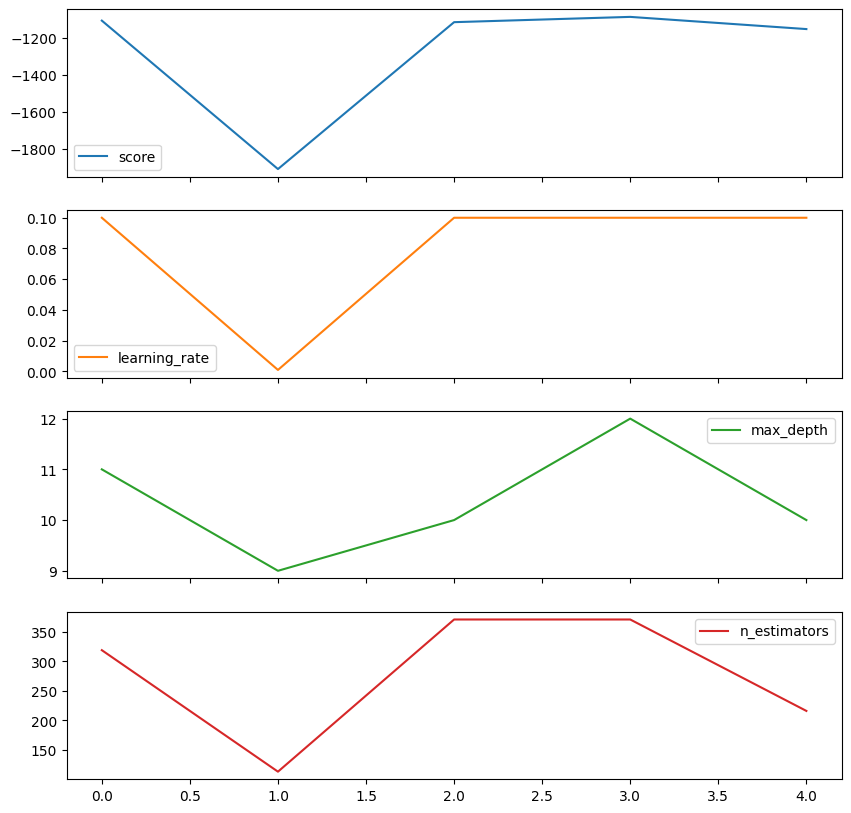

In [ ]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
best_params['random_state'] = 42
best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
best_mode = CatBoostRegressor(**best_params)

In [ ]:
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1160.4498879620996
2 번째 Stratified K-Fold RMSE: 1174.3370134919671
3 번째 Stratified K-Fold RMSE: 1148.7386710385438
4 번째 Stratified K-Fold RMSE: 1187.6263061825628
5 번째 Stratified K-Fold RMSE: 1185.4321890434246
--------------------------------------------------
교차 검증 RMSE: 1176.3914673679512


Text(0.5, 1.0, 'Feature Importance')

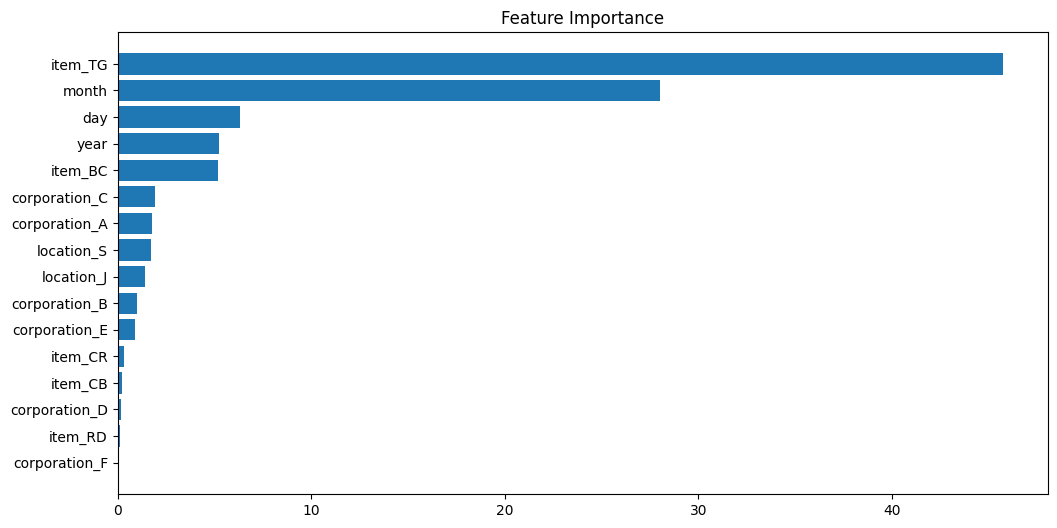

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(range(len(train_x)))[sorted_idx])
# 변수명이 있다면, 아래와 같이...
plt.yticks(range(len(sorted_idx)), np.array(train_x.columns)[sorted_idx])
plt.title('Feature Importance')

## 랜덤포레스트

### model 1

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
hp = {
    "random_state": 42,
    "verbose": 0  # 부스팅 단계 출력 안보이게 하기
}
model = RandomForestRegressor(**hp)  # RandomForestRegressor로 모델 변경
n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
    train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

    # 학습
    model.fit(train_x, train_y)
    valid_pred = model.predict(valid_x)  # 예측값

    # 평가
    rmse = mean_squared_error(valid_y, valid_pred, squared=False)
    rmse_lst.append(rmse)
    print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-' * 50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1175.8736315695007
2 번째 Stratified K-Fold RMSE: 1195.258196628822
3 번째 Stratified K-Fold RMSE: 1182.5754800662025
4 번째 Stratified K-Fold RMSE: 1203.7802903898187
5 번째 Stratified K-Fold RMSE: 1177.844232629002
--------------------------------------------------
교차 검증 RMSE: 1187.066366256669


### model 2

In [ ]:
hp = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
model = RandomForestRegressor(**hp)

In [ ]:
n_iter=5 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(10,500,30, dtype = int), # 부스팅 단계수
}

# HPO 인스턴스 생성
rs1 = RandomizedSearchCV(RandomForestRegressor(), hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=3)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: ignored

In [ ]:
best_params = rs1.best_params_
best_params

{'n_estimators': 364, 'max_depth': 11}

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

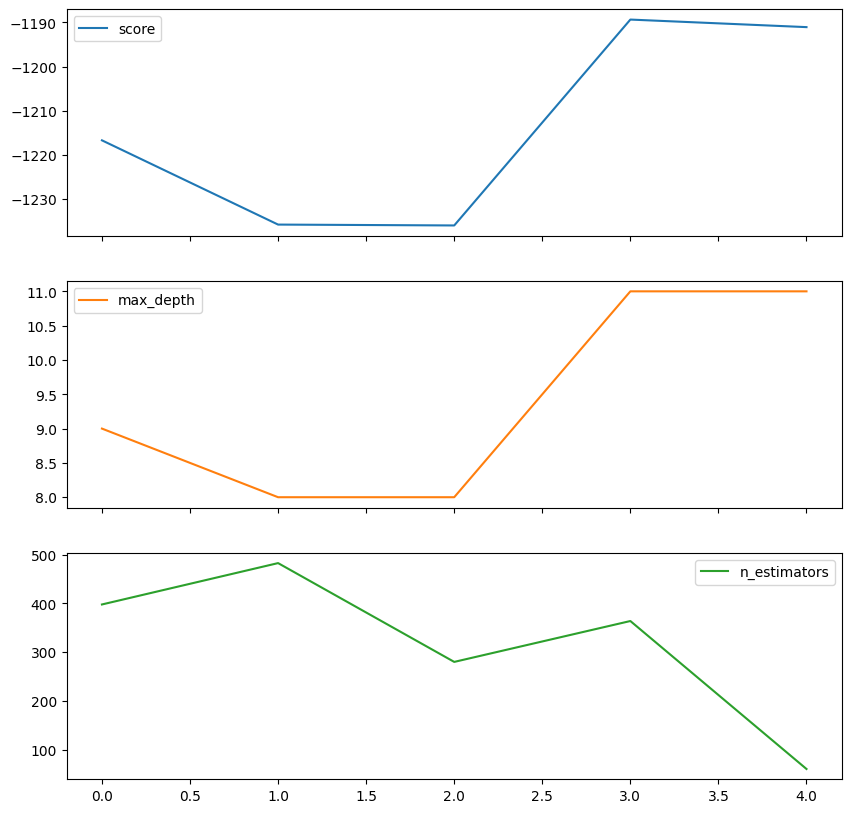

In [ ]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [ ]:
best_params['random_state'] = 42
best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
best_model = RandomForestRegressor(**best_params)

In [ ]:
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1175.8736315695007
2 번째 Stratified K-Fold RMSE: 1195.258196628822
3 번째 Stratified K-Fold RMSE: 1182.5754800662025
4 번째 Stratified K-Fold RMSE: 1203.7802903898187
5 번째 Stratified K-Fold RMSE: 1177.844232629002
--------------------------------------------------
교차 검증 RMSE: 1187.0663662566692


# train_y, pred RMSE

In [ ]:
model

RandomForestRegressor(random_state=42)

In [ ]:
pred = model.predict(train_x)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))
print(f'RMSE: {rmse}')

RMSE: 446.9301643393462


In [ ]:
train_y

,price(원/kg)
0,0.0
1,0.0
2,1728.0
3,1408.0
4,1250.0
...,...
59392,468.0
59393,531.0
59394,574.0
59395,523.0


In [ ]:
pred

array([   0.  ,    0.  , 1640.41, ...,  548.62,  543.43,  521.73])

In [ ]:
pred_df = pd.DataFrame(pred, columns=['price(원/kg)'])
pred_df

,price(원/kg)
0,0.00
1,0.00
2,1640.41
3,1432.65
4,1189.17
...,...
47513,347.95
47514,471.70
47515,548.62
47516,543.43


# 학습 평가

## 산포도

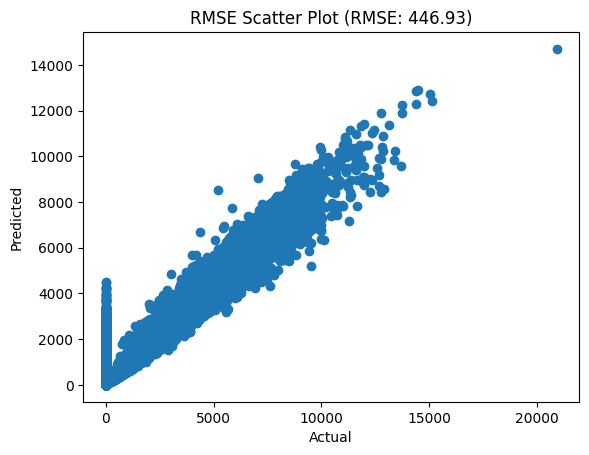

In [ ]:
import matplotlib.pyplot as plt

# train_y와 pred의 RMSE를 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))

# 산포도 그래프 생성
plt.scatter(train_y, pred)

# 그래프에 제목과 x축, y축 레이블 추가
plt.title(f'RMSE Scatter Plot (RMSE: {rmse:.2f})')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# 그래프 표시
plt.show()

## 예측 오차 히스토그램

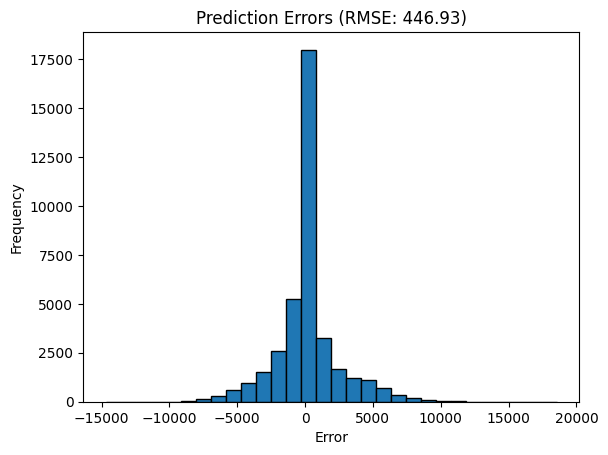

In [ ]:
# 예측 오차 계산
errors = train_y - pred_df

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))

# 히스토그램 생성
plt.hist(errors, bins=30, edgecolor='k')

# 그래프에 제목과 x축, y축 레이블 추가
plt.title(f'Prediction Errors (RMSE: {rmse:.2f})')
plt.xlabel('Error')
plt.ylabel('Frequency')

# 그래프 표시
plt.show()

## 오차의 절대값 히스토그램

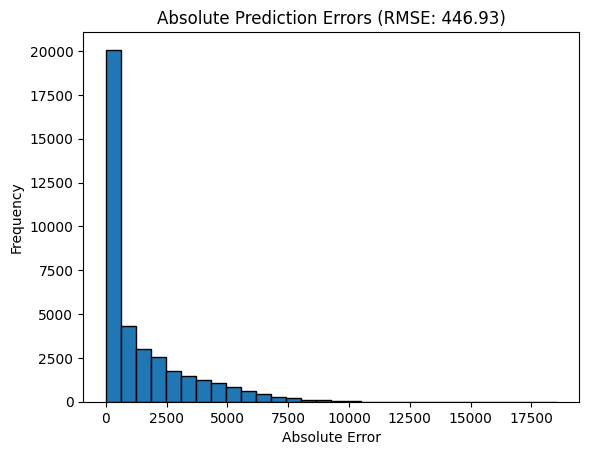

In [ ]:
# 예측 오차 계산 (절대값)
errors = np.abs(train_y - pred_df)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))

# 히스토그램 생성
plt.hist(errors, bins=30, edgecolor='k')

# 그래프에 제목과 x축, y축 레이블 추가
plt.title(f'Absolute Prediction Errors (RMSE: {rmse:.2f})')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')

# 그래프 표시
plt.show()

## 상위 오차 샘플 확인

In [ ]:
# 예측 오차 계산
errors = np.abs(train_y['price(원/kg)'] - pred)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred_df))

# 오차와 해당 오차가 속한 샘플의 인덱스를 결합하여 튜플로 만듭니다
error_samples = list(zip(errors, range(len(errors))))

# 오차를 기준으로 정렬합니다 (내림차순)
error_samples.sort(reverse=True, key=lambda x: x[0])

# 상위 N개의 오차 샘플을 확인합니다 (여기서는 상위 10개로 예시)
top_N = 10
top_errors = error_samples[:top_N]



# 결과 출력
for error, sample_idx in top_errors:
    true_value = float(train_y.iloc[sample_idx])
    predicted_value = float(pred[sample_idx])
    print(f'Sample Index: {sample_idx}, Error: {error}, True Value: {true_value:.2f}, Predicted Value: {predicted_value:.2f}')


Sample Index: 5848, Error: 6214.58, True Value: 20909.00, Predicted Value: 14694.42
Sample Index: 5553, Error: 4503.97, True Value: 0.00, Predicted Value: 4503.97
Sample Index: 5264, Error: 4441.0, True Value: 0.00, Predicted Value: 4441.00
Sample Index: 4966, Error: 4328.74, True Value: 12763.00, Predicted Value: 8434.26
Sample Index: 7978, Error: 4309.66, True Value: 9500.00, Predicted Value: 5190.34
Sample Index: 5865, Error: 4301.74, True Value: 12887.00, Predicted Value: 8585.26
Sample Index: 9535, Error: 4290.15, True Value: 0.00, Predicted Value: 4290.15
Sample Index: 4970, Error: 4250.19, True Value: 0.00, Predicted Value: 4250.19
Sample Index: 7070, Error: 4222.14, True Value: 0.00, Predicted Value: 4222.14
Sample Index: 3434, Error: 4205.26, True Value: 0.00, Predicted Value: 4205.26


## Residual Plot

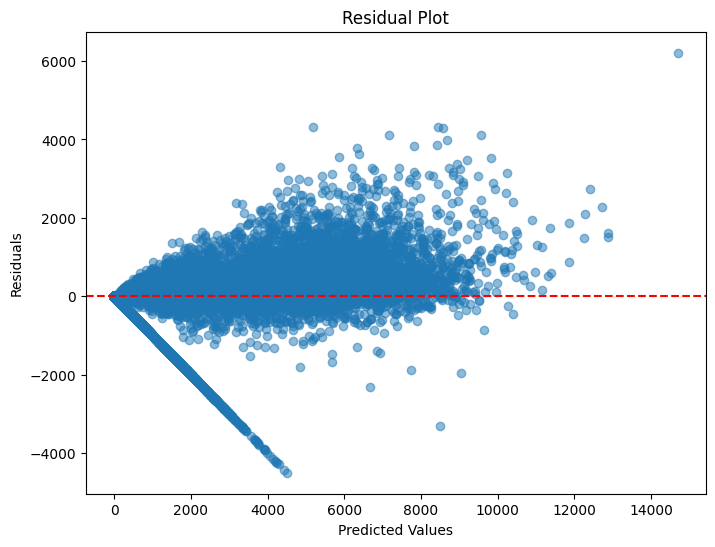

In [ ]:
# 예측값과 실제값의 차이 (잔차) 계산
residuals = train_y['price(원/kg)'] - pred

# Residual Plot 그리기
plt.figure(figsize=(8, 6))
plt.scatter(pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Submission

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/dev/ML_basic/sample_submission.csv')
submission

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0
...,...,...
1087,RD_F_J_20230327,0
1088,RD_F_J_20230328,0
1089,RD_F_J_20230329,0
1090,RD_F_J_20230330,0


In [ ]:
target_pred = model.predict(test_encoded)

In [ ]:
submission['answer'] = target_pred
submission

,ID,answer
0,TG_A_J_20230304,3393.97
1,TG_A_J_20230305,3153.67
2,TG_A_J_20230306,847.27
3,TG_A_J_20230307,3212.21
4,TG_A_J_20230308,3359.82
...,...,...
1087,RD_F_J_20230327,279.13
1088,RD_F_J_20230328,429.32
1089,RD_F_J_20230329,409.42
1090,RD_F_J_20230330,444.12


In [ ]:
submission.to_csv('./Hyul.csv', index=False)